In [100]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, LSTM, Embedding, Bidirectional
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import sys
import io
import re
from unidecode import unidecode
import os
from numpy import array
from pickle import dump, load
from random import randint
from nltk.translate.bleu_score import corpus_bleu
import gensim
from gensim.models import Word2Vec
import string

In [2]:
data = pd.read_csv('ed_sheeran.csv', names=["Song_Name", "Link", "Lyrics"])
data.head()

,Song_Name,Link,Lyrics
0,\nShe Looks So Perfect Lyrics\n,http://www.metrolyrics.com/she-looks-so-perfec...,"Hey, hey, hey, hey, Hey, hey, hey, hey, Hey, ..."
1,\nShape of You Lyrics\n,http://www.metrolyrics.com/shape-of-you-lyrics...,The club isn't the best place to find a lover...
2,\nPerfect Lyrics\n,http://www.metrolyrics.com/perfect-lyrics-ed-s...,"I found a love for me, Darling, just dive rig..."
3,\nPhotograph Lyrics\n,http://www.metrolyrics.com/photograph-lyrics-e...,"Loving can hurt, Loving can hurt sometimes, B..."
4,\nThinking Out Loud Lyrics\n,http://www.metrolyrics.com/thinking-out-loud-l...,When your legs don't work like they used to b...


In [80]:
# X = data[['Song_Name', 'Link']]
y = data['Lyrics']
# X_train, X_test, data_train, data_test = train_test_split(X, y, test_size=0.2, random_state=1)
split_at = int(0.8 * len(y))
y_train = y[: split_at]
y_test = y[split_at:]

In [4]:
def sequences_file(data, out_filename, n=50):
    """
    Function to generate a file of sequences containing n words in each line
    
    # Arguments
        data: Input dataframe containing only lyrics
        n: Number of words in a sequence. Default is 50
        out_filename: Path including filename to be saved (in '.txt')
        
    # Returns
        Total number of sequences in the generated file
    """
    def get_lines(df):
        corpus = []
        for index, row in df.iteritems():
            row = str(row).lower()
            for words in row.split(','):
                new_words = re.findall(r"\b[a-z']+\b", unidecode(words))
                corpus = corpus + new_words
        return corpus

    all_lines = get_lines(data)
    
    # organize into sequences of tokens
    SEQ_LENGTH = n + 1
    sequences = list()
    for i in range(SEQ_LENGTH, len(all_lines)):
        # select sequence of tokens
        seq = all_lines[i - SEQ_LENGTH: i]
        # convert into a line
        line = ' '.join(seq)
        # store
        sequences.append(line)
    print('Total Sequences: %d' % len(sequences))
        
    # save tokens to file, one dialog per line
    def save_doc(lines, filename):
        data = '\n'.join(lines)
        file = open(filename, 'w')
        file.write(data)
        file.close()

    # save sequences to file
    save_doc(sequences, out_filename)

In [5]:
sequences_file(y_train, 'train_seq.txt', 50)
sequences_file(y_test, 'test_seq.txt', 50)
sequences_file(data['Lyrics'], 'full_seq.txt', 50)

Total Sequences: 50628
Total Sequences: 11701
Total Sequences: 62380


In [115]:
def language_model(model_type, in_filename, embedding='word', bsize=256, epoc=25, lrate=0.001):
    """
    Function to generate a language model
    
    # Arguments
        model_type: Choose a model from ['rnn', 'bi_rnn', 'multi_rnn']
        in_filename: Path of input file containing sequences to be trianed on
        embedding: Choose a word embedding from ['word', 'glove', 'one_hot', 'word2vec']
        bsize: Batch size to fit the model on
        epoc: Number of epochs to be trained on
        lrate: Learning rate to be used
        
    # Returns
        Saves the model & tokenizer files and returns the filenames
    """
    # load doc into memory
    def load_doc(filename):
        # open the file as read only
        file = open(filename, 'r')
        # read all text
        text = file.read()
        # close the file
        file.close()
        return text

    # load
    doc = load_doc(in_filename)
    lines = doc.split('\n')

    # integer encode sequences of words
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    sequences = tokenizer.texts_to_sequences(lines)
    # vocabulary size
    vocab_size = len(tokenizer.word_index) + 1

    # separate into input and output
    sequences = array(sequences)
    a = int(0.8 * len(sequences))
    X, y = sequences[:a, :-1], sequences[:a, -1]
    y = to_categorical(y, num_classes=vocab_size)
    seq_length = X.shape[1]
    
    if embedding == 'glove':
        embeddings_index = {}
        f = open(os.path.join('/home/affine/Deep Learning/glove.6B/', 'glove.6B.100d.txt')) # change path & embeddings dimension accordingly
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        
        embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100)) # embedding_dim = 100 - using glove 100d
        for word, i in tokenizer.word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
                
    if embedding == 'word2vec':
        def word2vec_embed(df=data['Lyrics']):
            # creating a corpus for word2vec
            corpus = []
            for index, row in df.iteritems():
                new_words_1=[]
                row = str(row).lower()
                for words in row.split(','):
                    new_words = re.findall(r"\b[a-z']+\b", unidecode(words))
                    new_words_1 = new_words_1 + new_words
                corpus.append(new_words_1)
            
            # defining word2vec model
            model = Word2Vec(corpus, min_count=1, size=100, window=5)
            words = list(model.wv.vocab)

            # creating word2vec embedding matrix
            embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
            for word, i in tokenizer.word_index.items():
                embedding_vector = model.wv.__getitem__(word)
                if embedding_vector is not None:
                    # words not found in embedding index will be all-zeros.
                    embedding_matrix[i] = embedding_vector
            return embedding_matrix

        embedding_matrix = word2vec_embed()

    # define model
    model = Sequential()
    # adding embedding layer accordingly
    if embedding == 'glove' or embedding == 'word2vec':
        model.add(Embedding(vocab_size, 100, input_length=seq_length, weights=[embedding_matrix], trainable=True))
    else:
        model.add(Embedding(vocab_size, 50, input_length=seq_length))
    # adding rnn layers accordingly
    if model_type == 'rnn':
        model.add(LSTM(100, return_sequences=True))
        model.add(LSTM(100))
    elif model_type == 'bi_rnn':
        # LSTM Layer: We will initialise a bidirectional LSTM layer
        model.add(Bidirectional(LSTM(100, return_sequences=True)))
        # LSTM Layer: We will initialise another bidirectional LSTM layer
        model.add(Bidirectional(LSTM(100)))
    elif model_type == 'multi_rnn':
        model.add(LSTM(100, return_sequences=True))
        model.add(LSTM(100, return_sequences=True))
        model.add(LSTM(100))
    # adding dense layers           
    model.add(Dense(100, activation='relu'))
    model.add(Dense(vocab_size, activation='softmax'))
    print(model.summary())

    # compile model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=lrate), metrics=['accuracy'])
    # fit model
    model.fit(X, y, batch_size=bsize, epochs=epoc)

    # save the model to file
    model.save(model_type + embedding + str(bsize) + str(epoc) + str(int(lrate * 10000)) + '.h5')
    # save the tokenizer
    dump(tokenizer, open(model_type + embedding + str(bsize) + str(epoc) + str(int(lrate * 10000)) + '_tokenizer.pkl', 'wb'))
    return model_type + embedding + str(bsize) + str(epoc) + str(int(lrate * 10000)) + '.h5', model_type + embedding + str(bsize) + str(epoc) + str(int(lrate * 10000)) + '_tokenizer.pkl'

In [84]:
def generate_song(in_filename, model_file, tokenizer_pickle_file):
    """
    Function to generate a language model
    
    # Arguments
        in_filename: Path of input file containing sequences
        model_file: Path of trained model name to be used for prediction
        tokenizer_pickle_file: Path of tokenizer pickle file to be used
        
    # Returns
        Prints the input sequence, sequence to be followed & predicted sequence and
        returns Bleu scores considering 1, 2, 3, 4 - grams
    """
    # load doc into memory
    def load_doc(filename):
        # open the file as read only
        file = open(filename, 'r')
        # read all text
        text = file.read()
        # close the file
        file.close()
        return text

    # generate a sequence from a language model
    def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
        result = list()
        in_text = seed_text
        # generate a fixed number of words
        for _ in range(n_words):
            # encode the text as integer
            encoded = tokenizer.texts_to_sequences([in_text])[0]
            # truncate sequences to a fixed length
            encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
            # predict probabilities for each word
            yhat = model.predict_classes(encoded, verbose=0)
            # map predicted word index to word
            out_word = ''
            for word, index in tokenizer.word_index.items():
                if index == yhat:
                    out_word = word
                    break
            # append to input
            in_text += ' ' + out_word
            result.append(out_word)
        return ' '.join(result)

    # load cleaned text sequences
    doc = load_doc(in_filename)
    lines = doc.split('\n')
    seq_length = len(lines[0].split()) - 1

    # load the model
    model = load_model(model_file)

    # load the tokenizer
    tokenizer = load(open(tokenizer_pickle_file, 'rb'))

    # select a seed text
#     seed_num = randint(0,len(lines))
    seed_num = 1000
    seed_text = lines[seed_num]
    print('Input text -----')
    print(seed_text + '\n')
    
    # actual text
    actual = []
    act_text = lines[seed_num + 51]
    print('Actual text -----')
    print(act_text + '\n')
    actual.append([act_text.split()])
    
    # generate new text
    predicted = []
    generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
    print('Predicted text -----')
    print(generated)
    predicted.append(generated.split())
    
#     return ('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    return corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)), corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)), corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)), corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

In [12]:
language_model('multi_rnn', 'full_seq.txt', 'glove', epoc=50)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           304400    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 100)           80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 3044)              307444    
Total params: 863,144
Trainable params: 863,144
Non-trainable params: 0
________________________________________________

/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
49904/49904 [==============================] - 72s 1ms/step - loss: 6.1869 - accuracy: 0.0370
Epoch 2/50
49904/49904 [==============================] - 75s 2ms/step - loss: 5.9647 - accuracy: 0.0406
Epoch 3/50
49904/49904 [==============================] - 81s 2ms/step - loss: 5.7609 - accuracy: 0.0461
Epoch 4/50
49904/49904 [==============================] - 80s 2ms/step - loss: 5.3893 - accuracy: 0.0702
Epoch 5/50
49904/49904 [==============================] - 73s 1ms/step - loss: 5.0750 - accuracy: 0.0884
Epoch 6/50
49904/49904 [==============================] - 71s 1ms/step - loss: 4.8170 - accuracy: 0.1133
Epoch 7/50
49904/49904 [==============================] - 70s 1ms/step - loss: 4.5663 - accuracy: 0.1383
Epoch 8/50
49904/49904 [==============================] - 71s 1ms/step - loss: 4.3235 - accuracy: 0.1657
Epoch 9/50
49904/49904 [==============================] - 70s 1ms/step - loss: 4.0965 - accuracy: 0.1924
Epoch 10/50
49904/49904 [==============================

In [15]:
language_model('bi_rnn', 'full_seq.txt', 'glove', epoc=50)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           304400    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 200)           160800    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_4 (Dense)              (None, 3044)              307444    
Total params: 1,033,544
Trainable params: 1,033,544
Non-trainable params: 0
_________________________________________________________________
None


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
49904/49904 [==============================] - 92s 2ms/step - loss: 6.1233 - accuracy: 0.0399
Epoch 2/50
49904/49904 [==============================] - 89s 2ms/step - loss: 5.5315 - accuracy: 0.0682
Epoch 3/50
49904/49904 [==============================] - 91s 2ms/step - loss: 5.0600 - accuracy: 0.1088
Epoch 4/50
49904/49904 [==============================] - 90s 2ms/step - loss: 4.7151 - accuracy: 0.1413
Epoch 5/50
49904/49904 [==============================] - 89s 2ms/step - loss: 4.4169 - accuracy: 0.1715
Epoch 6/50
49904/49904 [==============================] - 89s 2ms/step - loss: 4.1252 - accuracy: 0.2054
Epoch 7/50
49904/49904 [==============================] - 91s 2ms/step - loss: 3.8447 - accuracy: 0.2399
Epoch 8/50
49904/49904 [==============================] - 90s 2ms/step - loss: 3.5719 - accuracy: 0.2773
Epoch 9/50
49904/49904 [==============================] - 90s 2ms/step - loss: 3.3049 - accuracy: 0.3196
Epoch 10/50
49904/49904 [==============================

In [16]:
language_model('rnn', 'full_seq.txt', 'glove', epoc=50)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           304400    
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 100)           80400     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 3044)              307444    
Total params: 782,744
Trainable params: 782,744
Non-trainable params: 0
_________________________________________________________________
None


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
49904/49904 [==============================] - 48s 972us/step - loss: 6.1798 - accuracy: 0.0387
Epoch 2/50
49904/49904 [==============================] - 48s 964us/step - loss: 5.7939 - accuracy: 0.0424
Epoch 3/50
49904/49904 [==============================] - 49s 972us/step - loss: 5.4385 - accuracy: 0.0675
Epoch 4/50
49904/49904 [==============================] - 48s 967us/step - loss: 5.1141 - accuracy: 0.0937
Epoch 5/50
49904/49904 [==============================] - 47s 951us/step - loss: 4.8149 - accuracy: 0.1230
Epoch 6/50
49904/49904 [==============================] - 47s 949us/step - loss: 4.5402 - accuracy: 0.1515
Epoch 7/50
49904/49904 [==============================] - 47s 949us/step - loss: 4.2804 - accuracy: 0.1785
Epoch 8/50
49904/49904 [==============================] - 47s 949us/step - loss: 4.0442 - accuracy: 0.2037
Epoch 9/50
49904/49904 [==============================] - 47s 950us/step - loss: 3.8245 - accuracy: 0.2284
Epoch 10/50
49904/49904 [============

In [ ]:
language_model('multi_rnn', 'full_seq.txt', epoc=50)

In [18]:
language_model('bi_rnn', 'full_seq.txt', epoc=50)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 50)            152200    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_9 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_10 (Dense)             (None, 3044)              307444    
Total params: 841,344
Trainable params: 841,344
Non-trainable params: 0
_________________________________________________________________
None


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
49904/49904 [==============================] - 86s 2ms/step - loss: 6.1951 - accuracy: 0.0382
Epoch 2/50
49904/49904 [==============================] - 84s 2ms/step - loss: 5.7531 - accuracy: 0.0455
Epoch 3/50
49904/49904 [==============================] - 84s 2ms/step - loss: 5.4619 - accuracy: 0.0654
Epoch 4/50
49904/49904 [==============================] - 85s 2ms/step - loss: 5.2581 - accuracy: 0.0812
Epoch 5/50
49904/49904 [==============================] - 85s 2ms/step - loss: 5.1316 - accuracy: 0.0924
Epoch 6/50
49904/49904 [==============================] - 84s 2ms/step - loss: 4.9847 - accuracy: 0.1006
Epoch 7/50
49904/49904 [==============================] - 85s 2ms/step - loss: 4.8098 - accuracy: 0.1124
Epoch 8/50
49904/49904 [==============================] - 85s 2ms/step - loss: 4.6627 - accuracy: 0.1251
Epoch 9/50
49904/49904 [==============================] - 85s 2ms/step - loss: 4.5341 - accuracy: 0.1357
Epoch 10/50
49904/49904 [==============================

In [19]:
language_model('rnn', 'full_seq.txt', epoc=50)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 50)            152200    
_________________________________________________________________
lstm_14 (LSTM)               (None, 50, 100)           60400     
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 3044)              307444    
Total params: 610,544
Trainable params: 610,544
Non-trainable params: 0
_________________________________________________________________
None


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
49904/49904 [==============================] - 45s 908us/step - loss: 6.2142 - accuracy: 0.0365
Epoch 2/50
49904/49904 [==============================] - 44s 891us/step - loss: 5.8589 - accuracy: 0.0406
Epoch 3/50
49904/49904 [==============================] - 45s 892us/step - loss: 5.6013 - accuracy: 0.0485
Epoch 4/50
49904/49904 [==============================] - 45s 892us/step - loss: 5.4184 - accuracy: 0.0604
Epoch 5/50
49904/49904 [==============================] - 45s 893us/step - loss: 5.2555 - accuracy: 0.0758
Epoch 6/50
49904/49904 [==============================] - 45s 892us/step - loss: 5.1063 - accuracy: 0.0902
Epoch 7/50
49904/49904 [==============================] - 44s 892us/step - loss: 4.9639 - accuracy: 0.1012
Epoch 8/50
49904/49904 [==============================] - 44s 891us/step - loss: 4.8173 - accuracy: 0.1133
Epoch 9/50
49904/49904 [==============================] - 45s 893us/step - loss: 4.6473 - accuracy: 0.1280
Epoch 10/50
49904/49904 [============

In [20]:
language_model('multi_rnn', 'full_seq.txt', 'glove', bsize=128, epoc=35, lrate=0.01)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 100)           304400    
_________________________________________________________________
lstm_16 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
lstm_17 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
lstm_18 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 3044)              307444    
Total params: 863,144
Trainable params: 863,144
Non-trainable params: 0
________________________________________________

/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/35
49904/49904 [==============================] - 78s 2ms/step - loss: 6.0368 - accuracy: 0.0411
Epoch 2/35
49904/49904 [==============================] - 77s 2ms/step - loss: 5.4755 - accuracy: 0.0675
Epoch 3/35
49904/49904 [==============================] - 77s 2ms/step - loss: 5.0749 - accuracy: 0.1016
Epoch 4/35
49904/49904 [==============================] - 77s 2ms/step - loss: 4.7336 - accuracy: 0.1377
Epoch 5/35
49904/49904 [==============================] - 77s 2ms/step - loss: 4.4384 - accuracy: 0.1722
Epoch 6/35
49904/49904 [==============================] - 77s 2ms/step - loss: 4.1938 - accuracy: 0.2036
Epoch 7/35
49904/49904 [==============================] - 77s 2ms/step - loss: 3.9832 - accuracy: 0.2282
Epoch 8/35
49904/49904 [==============================] - 77s 2ms/step - loss: 3.8236 - accuracy: 0.2478
Epoch 9/35
49904/49904 [==============================] - 77s 2ms/step - loss: 3.6720 - accuracy: 0.2661
Epoch 10/35
49904/49904 [==============================

In [ ]:
language_model('bi_rnn', 'full_seq.txt', 'glove', bsize=128, epoc=30, lrate=0.01)

In [22]:
language_model('rnn', 'full_seq.txt', 'glove', bsize=128, epoc=30, lrate=0.01)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 100)           304400    
_________________________________________________________________
lstm_21 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
lstm_22 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_17 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_18 (Dense)             (None, 3044)              307444    
Total params: 782,744
Trainable params: 782,744
Non-trainable params: 0
_________________________________________________________________
None


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
49904/49904 [==============================] - 54s 1ms/step - loss: 5.7458 - accuracy: 0.0600
Epoch 2/30
49904/49904 [==============================] - 53s 1ms/step - loss: 4.8322 - accuracy: 0.1411
Epoch 3/30
49904/49904 [==============================] - 53s 1ms/step - loss: 4.2656 - accuracy: 0.2018
Epoch 4/30
49904/49904 [==============================] - 53s 1ms/step - loss: 3.8318 - accuracy: 0.2525
Epoch 5/30
49904/49904 [==============================] - 53s 1ms/step - loss: 3.4922 - accuracy: 0.3002
Epoch 6/30
49904/49904 [==============================] - 53s 1ms/step - loss: 3.1900 - accuracy: 0.3453
Epoch 7/30
49904/49904 [==============================] - 53s 1ms/step - loss: 2.9309 - accuracy: 0.3850
Epoch 8/30
49904/49904 [==============================] - 53s 1ms/step - loss: 2.7173 - accuracy: 0.4213
Epoch 9/30
49904/49904 [==============================] - 53s 1ms/step - loss: 2.5467 - accuracy: 0.4507
Epoch 10/30
49904/49904 [==============================

In [117]:
language_model('rnn', 'full_seq.txt', embedding='word2vec', bsize=256, epoc=50, lrate=0.001)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 50, 100)           304400    
_________________________________________________________________
lstm_65 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
lstm_66 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_61 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_62 (Dense)             (None, 3044)              307444    
Total params: 782,744
Trainable params: 782,744
Non-trainable params: 0
_________________________________________________________________
None


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
49904/49904 [==============================] - 49s 981us/step - loss: 6.1834 - accuracy: 0.0359
Epoch 2/50
49904/49904 [==============================] - 49s 973us/step - loss: 5.8617 - accuracy: 0.0406
Epoch 3/50
49904/49904 [==============================] - 49s 987us/step - loss: 5.5702 - accuracy: 0.0552
Epoch 4/50
49904/49904 [==============================] - 49s 975us/step - loss: 5.2022 - accuracy: 0.0787
Epoch 5/50
49904/49904 [==============================] - 50s 996us/step - loss: 4.9226 - accuracy: 0.0980
Epoch 6/50
49904/49904 [==============================] - 52s 1ms/step - loss: 4.6747 - accuracy: 0.1245
Epoch 7/50
49904/49904 [==============================] - 50s 994us/step - loss: 4.4470 - accuracy: 0.1497
Epoch 8/50
49904/49904 [==============================] - 48s 964us/step - loss: 4.2371 - accuracy: 0.1744
Epoch 9/50
49904/49904 [==============================] - 48s 964us/step - loss: 4.0373 - accuracy: 0.1990
Epoch 10/50
49904/49904 [==============

('rnnword2vec2565010.h5', 'rnnword2vec2565010_tokenizer.pkl')

In [118]:
language_model('bi_rnn', 'full_seq.txt', embedding='word2vec', bsize=256, epoc=50, lrate=0.001)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 50, 100)           304400    
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 50, 200)           160800    
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 200)               240800    
_________________________________________________________________
dense_63 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_64 (Dense)             (None, 3044)              307444    
Total params: 1,033,544
Trainable params: 1,033,544
Non-trainable params: 0
_________________________________________________________________
None


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
49904/49904 [==============================] - 92s 2ms/step - loss: 6.1552 - accuracy: 0.0371
Epoch 2/50
49904/49904 [==============================] - 91s 2ms/step - loss: 5.6378 - accuracy: 0.0584
Epoch 3/50
49904/49904 [==============================] - 91s 2ms/step - loss: 5.1938 - accuracy: 0.0834
Epoch 4/50
49904/49904 [==============================] - 91s 2ms/step - loss: 4.8706 - accuracy: 0.1124
Epoch 5/50
49904/49904 [==============================] - 91s 2ms/step - loss: 4.5984 - accuracy: 0.1447
Epoch 6/50
49904/49904 [==============================] - 91s 2ms/step - loss: 4.3570 - accuracy: 0.1703
Epoch 7/50
49904/49904 [==============================] - 91s 2ms/step - loss: 4.1424 - accuracy: 0.1930
Epoch 8/50
49904/49904 [==============================] - 91s 2ms/step - loss: 3.9308 - accuracy: 0.2167
Epoch 9/50
49904/49904 [==============================] - 91s 2ms/step - loss: 3.7299 - accuracy: 0.2433
Epoch 10/50
49904/49904 [==============================

('bi_rnnword2vec2565010.h5', 'bi_rnnword2vec2565010_tokenizer.pkl')

In [119]:
language_model('multi_rnn', 'full_seq.txt', embedding='word2vec', bsize=256, epoc=50, lrate=0.001)

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 50, 100)           304400    
_________________________________________________________________
lstm_69 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
lstm_70 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
lstm_71 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_65 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_66 (Dense)             (None, 3044)              307444    
Total params: 863,144
Trainable params: 863,144
Non-trainable params: 0
_______________________________________________

/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/50
49904/49904 [==============================] - 71s 1ms/step - loss: 6.2013 - accuracy: 0.0377
Epoch 2/50
49904/49904 [==============================] - 70s 1ms/step - loss: 5.9708 - accuracy: 0.0396
Epoch 3/50
49904/49904 [==============================] - 70s 1ms/step - loss: 5.9636 - accuracy: 0.0397
Epoch 4/50
49904/49904 [==============================] - 70s 1ms/step - loss: 5.7553 - accuracy: 0.0421
Epoch 5/50
49904/49904 [==============================] - 70s 1ms/step - loss: 5.3716 - accuracy: 0.0620
Epoch 6/50
49904/49904 [==============================] - 70s 1ms/step - loss: 5.0958 - accuracy: 0.0788
Epoch 7/50
49904/49904 [==============================] - 70s 1ms/step - loss: 4.8758 - accuracy: 0.0974
Epoch 8/50
49904/49904 [==============================] - 70s 1ms/step - loss: 4.6699 - accuracy: 0.1150
Epoch 9/50
49904/49904 [==============================] - 70s 1ms/step - loss: 4.4774 - accuracy: 0.1362
Epoch 10/50
49904/49904 [==============================

('multi_rnnword2vec2565010.h5', 'multi_rnnword2vec2565010_tokenizer.pkl')

In [73]:
bleu_df = pd.DataFrame(columns=['epochs', '1_gram', '2_gram', '3_gram', '4_gram'])
for i in [5, 15, 25, 35, 45]:
    mname, tokens = language_model('bi_rnn', 'full_seq.txt', 'glove', epoc=i)
    g_1, g_2, g_3, g_4 = generate_song('test_seq.txt', mname, tokens)
    df = pd.DataFrame([[i, g_1, g_2, g_3, g_4]], columns=['epochs', '1_gram', '2_gram', '3_gram', '4_gram'])
    bleu_df = bleu_df.append(df, ignore_index=True)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 50, 100)           304400    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 50, 200)           160800    
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 200)               240800    
_________________________________________________________________
dense_39 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_40 (Dense)             (None, 3044)              307444    
Total params: 1,033,544
Trainable params: 1,033,544
Non-trainable params: 0
_________________________________________________________________
None


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
49904/49904 [==============================] - 108s 2ms/step - loss: 6.1241 - accuracy: 0.0383
Epoch 2/5
49904/49904 [==============================] - 104s 2ms/step - loss: 5.6058 - accuracy: 0.0632
Epoch 3/5
49904/49904 [==============================] - 92s 2ms/step - loss: 5.1325 - accuracy: 0.1020
Epoch 4/5
49904/49904 [==============================] - 92s 2ms/step - loss: 4.7427 - accuracy: 0.1366
Epoch 5/5
49904/49904 [==============================] - 91s 2ms/step - loss: 4.4016 - accuracy: 0.1740


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Input text -----
monastery i'm not cut out for life on the road cause i didn't know i'd miss you this much and at the time we'd just go so sue me i guess i'm not the man that you need ever since you went to uni i've been sofa surfing with a rucksack

Actual text -----
full of less cash and i guess that could get bad but when i broke the industry that's when i broke your heart i was supposed to chart and celebrate but good things are over fast i know it's hard to deal with and see this i tend to turn you

Predicted text -----
tonight and i see you were the hill of the mountain of the woman's side and i see you were the hill of the mountain of the woman's side and i see you were the mountain of the woman's tonight and i see you were the hill of the woman's


/home/affine/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/affine/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 50, 100)           304400    
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 50, 200)           160800    
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 200)               240800    
_________________________________________________________________
dense_41 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_42 (Dense)             (None, 3044)              307444    
Total params: 1,033,544
Trainable params: 1,033,544
Non-trainable params: 0
_________________________________________________________________
None


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/15
49904/49904 [==============================] - 94s 2ms/step - loss: 6.1178 - accuracy: 0.0388
Epoch 2/15
49904/49904 [==============================] - 92s 2ms/step - loss: 5.5378 - accuracy: 0.0705
Epoch 3/15
49904/49904 [==============================] - 91s 2ms/step - loss: 5.0478 - accuracy: 0.1114
Epoch 4/15
49904/49904 [==============================] - 91s 2ms/step - loss: 4.6466 - accuracy: 0.1482
Epoch 5/15
49904/49904 [==============================] - 91s 2ms/step - loss: 4.3185 - accuracy: 0.1838
Epoch 6/15
49904/49904 [==============================] - 91s 2ms/step - loss: 4.0379 - accuracy: 0.2141
Epoch 7/15
49904/49904 [==============================] - 91s 2ms/step - loss: 3.7735 - accuracy: 0.2484
Epoch 8/15
49904/49904 [==============================] - 91s 2ms/step - loss: 3.5166 - accuracy: 0.2871
Epoch 9/15
49904/49904 [==============================] - 91s 2ms/step - loss: 3.2665 - accuracy: 0.3241
Epoch 10/15
49904/49904 [==============================

/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Input text -----
monastery i'm not cut out for life on the road cause i didn't know i'd miss you this much and at the time we'd just go so sue me i guess i'm not the man that you need ever since you went to uni i've been sofa surfing with a rucksack

Actual text -----
full of less cash and i guess that could get bad but when i broke the industry that's when i broke your heart i was supposed to chart and celebrate but good things are over fast i know it's hard to deal with and see this i tend to turn you

Predicted text -----
full of the age of water i only show the phone but i've got to the age of the age of the age of the riches stuck in the second girl and a boy that lives they got a keep in the resurrection's tee and i know that we've been


/home/affine/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/affine/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 50, 100)           304400    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 50, 200)           160800    
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 200)               240800    
_________________________________________________________________
dense_43 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_44 (Dense)             (None, 3044)              307444    
Total params: 1,033,544
Trainable params: 1,033,544
Non-trainable params: 0
_________________________________________________________________
None


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/25
49904/49904 [==============================] - 92s 2ms/step - loss: 6.1005 - accuracy: 0.0400
Epoch 2/25
49904/49904 [==============================] - 91s 2ms/step - loss: 5.5316 - accuracy: 0.0755
Epoch 3/25
49904/49904 [==============================] - 90s 2ms/step - loss: 5.0346 - accuracy: 0.1135
Epoch 4/25
49904/49904 [==============================] - 91s 2ms/step - loss: 4.6544 - accuracy: 0.1490
Epoch 5/25
49904/49904 [==============================] - 91s 2ms/step - loss: 4.3073 - accuracy: 0.1860
Epoch 6/25
49904/49904 [==============================] - 91s 2ms/step - loss: 4.0243 - accuracy: 0.2172
Epoch 7/25
49904/49904 [==============================] - 91s 2ms/step - loss: 3.7269 - accuracy: 0.2556
Epoch 8/25
49904/49904 [==============================] - 91s 2ms/step - loss: 3.4475 - accuracy: 0.2969
Epoch 9/25
49904/49904 [==============================] - 91s 2ms/step - loss: 3.1701 - accuracy: 0.3424
Epoch 10/25
49904/49904 [==============================

/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Input text -----
monastery i'm not cut out for life on the road cause i didn't know i'd miss you this much and at the time we'd just go so sue me i guess i'm not the man that you need ever since you went to uni i've been sofa surfing with a rucksack

Actual text -----
full of less cash and i guess that could get bad but when i broke the industry that's when i broke your heart i was supposed to chart and celebrate but good things are over fast i know it's hard to deal with and see this i tend to turn you

Predicted text -----
full of stone and your brother whispering now for the no to make the bank and everyday that someone's got to pay me i gave you my genre i'm still getting for phrases this been for the time that every day in the time that can be asking me i


/home/affine/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/affine/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 50, 100)           304400    
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 50, 200)           160800    
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 200)               240800    
_________________________________________________________________
dense_45 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_46 (Dense)             (None, 3044)              307444    
Total params: 1,033,544
Trainable params: 1,033,544
Non-trainable params: 0
_________________________________________________________________
None


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/35
49904/49904 [==============================] - 92s 2ms/step - loss: 6.0974 - accuracy: 0.0376
Epoch 2/35
49904/49904 [==============================] - 91s 2ms/step - loss: 5.5356 - accuracy: 0.0690
Epoch 3/35
49904/49904 [==============================] - 91s 2ms/step - loss: 5.0858 - accuracy: 0.1095
Epoch 4/35
49904/49904 [==============================] - 92s 2ms/step - loss: 4.7139 - accuracy: 0.1392
Epoch 5/35
49904/49904 [==============================] - 92s 2ms/step - loss: 4.3893 - accuracy: 0.1769
Epoch 6/35
49904/49904 [==============================] - 92s 2ms/step - loss: 4.0880 - accuracy: 0.2117
Epoch 7/35
49904/49904 [==============================] - 92s 2ms/step - loss: 3.8024 - accuracy: 0.2485
Epoch 8/35
49904/49904 [==============================] - 92s 2ms/step - loss: 3.5257 - accuracy: 0.2880
Epoch 9/35
49904/49904 [==============================] - 92s 2ms/step - loss: 3.2479 - accuracy: 0.3291
Epoch 10/35
49904/49904 [==============================

/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Input text -----
monastery i'm not cut out for life on the road cause i didn't know i'd miss you this much and at the time we'd just go so sue me i guess i'm not the man that you need ever since you went to uni i've been sofa surfing with a rucksack

Actual text -----
full of less cash and i guess that could get bad but when i broke the industry that's when i broke your heart i was supposed to chart and celebrate but good things are over fast i know it's hard to deal with and see this i tend to turn you

Predicted text -----
full of less cash and i know this to be but tragically our love just fun i was to give you wide tell you that it take it back can change your eyes until my soul is my head at your head are a year i'm living and may i
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 50, 100)           304400    
_______________________________

/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/45
49904/49904 [==============================] - 93s 2ms/step - loss: 6.1011 - accuracy: 0.0390
Epoch 2/45
49904/49904 [==============================] - 92s 2ms/step - loss: 5.5148 - accuracy: 0.0759
Epoch 3/45
49904/49904 [==============================] - 92s 2ms/step - loss: 5.0495 - accuracy: 0.1155
Epoch 4/45
49904/49904 [==============================] - 92s 2ms/step - loss: 4.6475 - accuracy: 0.1512
Epoch 5/45
49904/49904 [==============================] - 92s 2ms/step - loss: 4.3181 - accuracy: 0.1859
Epoch 6/45
49904/49904 [==============================] - 92s 2ms/step - loss: 4.0203 - accuracy: 0.2205
Epoch 7/45
49904/49904 [==============================] - 92s 2ms/step - loss: 3.7461 - accuracy: 0.2567
Epoch 8/45
49904/49904 [==============================] - 92s 2ms/step - loss: 3.4845 - accuracy: 0.2919
Epoch 9/45
49904/49904 [==============================] - 92s 2ms/step - loss: 3.2228 - accuracy: 0.3327
Epoch 10/45
49904/49904 [==============================

/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Input text -----
monastery i'm not cut out for life on the road cause i didn't know i'd miss you this much and at the time we'd just go so sue me i guess i'm not the man that you need ever since you went to uni i've been sofa surfing with a rucksack

Actual text -----
full of less cash and i guess that could get bad but when i broke the industry that's when i broke your heart i was supposed to chart and celebrate but good things are over fast i know it's hard to deal with and see this i tend to turn you

Predicted text -----
full of less cash and i guess that i've got too much because the memories of me i can i thought i'd never dies but i say it i would be get all that's all my phone and i need to get all or start it in now things keep


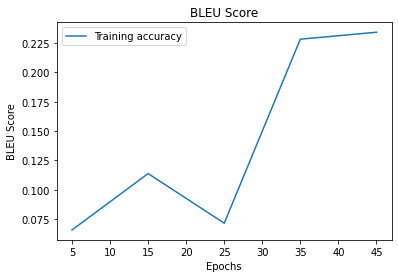

In [77]:
import matplotlib.pyplot as plt
plt.plot(bleu_df['epochs'], bleu_df['2_gram'], label='Training accuracy')
plt.title('BLEU Score')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
# plt.xticks(range(5, len(list(bleu_df['epochs'])) + 10))
plt.legend()
plt.show()

In [76]:
bleu_df

,epochs,1_gram,2_gram,3_gram,4_gram
0,5,0.215644,0.065679,9.799083e-94,3.784800e-155
1,15,0.215644,0.113760,1.362454e-93,4.981077e-155
2,25,0.254852,0.071401,1.030269e-93,3.946214e-155
3,35,0.372475,0.228379,1.940731e-01,1.277750e-01
4,45,0.392079,0.234312,2.225747e-01,1.627422e-01


In [85]:
bleu_df_2 = pd.DataFrame(columns=['epochs', '1_gram', '2_gram', '3_gram', '4_gram'])
for i in [5, 15, 25, 35, 45]:
    mname, tokens = language_model('rnn', 'full_seq.txt', 'glove', epoc=i)
    g_1, g_2, g_3, g_4 = generate_song('test_seq.txt', mname, tokens)
    df = pd.DataFrame([[i, g_1, g_2, g_3, g_4]], columns=['epochs', '1_gram', '2_gram', '3_gram', '4_gram'])
    bleu_df_2 = bleu_df_2.append(df, ignore_index=True)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 50, 100)           304400    
_________________________________________________________________
lstm_53 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
lstm_54 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_49 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_50 (Dense)             (None, 3044)              307444    
Total params: 782,744
Trainable params: 782,744
Non-trainable params: 0
_________________________________________________________________
None


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
49904/49904 [==============================] - 50s 998us/step - loss: 6.1861 - accuracy: 0.0355
Epoch 2/5
49904/49904 [==============================] - 50s 997us/step - loss: 5.7365 - accuracy: 0.0463
Epoch 3/5
49904/49904 [==============================] - 51s 1ms/step - loss: 5.3741 - accuracy: 0.0747
Epoch 4/5
49904/49904 [==============================] - 50s 997us/step - loss: 5.0631 - accuracy: 0.0983
Epoch 5/5
49904/49904 [==============================] - 49s 980us/step - loss: 4.7782 - accuracy: 0.1265


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Input text -----
monastery i'm not cut out for life on the road cause i didn't know i'd miss you this much and at the time we'd just go so sue me i guess i'm not the man that you need ever since you went to uni i've been sofa surfing with a rucksack

Actual text -----
full of less cash and i guess that could get bad but when i broke the industry that's when i broke your heart i was supposed to chart and celebrate but good things are over fast i know it's hard to deal with and see this i tend to turn you

Predicted text -----
one and i see the la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la la


/home/affine/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/affine/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 50, 100)           304400    
_________________________________________________________________
lstm_55 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
lstm_56 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_51 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_52 (Dense)             (None, 3044)              307444    
Total params: 782,744
Trainable params: 782,744
Non-trainable params: 0
_________________________________________________________________
None


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/15
49904/49904 [==============================] - 51s 1ms/step - loss: 6.1659 - accuracy: 0.0399
Epoch 2/15
49904/49904 [==============================] - 49s 974us/step - loss: 5.7554 - accuracy: 0.0459
Epoch 3/15
49904/49904 [==============================] - 49s 977us/step - loss: 5.3984 - accuracy: 0.0729
Epoch 4/15
49904/49904 [==============================] - 50s 1ms/step - loss: 5.0709 - accuracy: 0.0990
Epoch 5/15
49904/49904 [==============================] - 50s 1ms/step - loss: 4.7798 - accuracy: 0.1259
Epoch 6/15
49904/49904 [==============================] - 49s 986us/step - loss: 4.4984 - accuracy: 0.1564
Epoch 7/15
49904/49904 [==============================] - 49s 986us/step - loss: 4.2509 - accuracy: 0.1817
Epoch 8/15
49904/49904 [==============================] - 48s 965us/step - loss: 4.0226 - accuracy: 0.2060
Epoch 9/15
49904/49904 [==============================] - 48s 970us/step - loss: 3.8178 - accuracy: 0.2304
Epoch 10/15
49904/49904 [==================

/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Input text -----
monastery i'm not cut out for life on the road cause i didn't know i'd miss you this much and at the time we'd just go so sue me i guess i'm not the man that you need ever since you went to uni i've been sofa surfing with a rucksack

Actual text -----
full of less cash and i guess that could get bad but when i broke the industry that's when i broke your heart i was supposed to chart and celebrate but good things are over fast i know it's hard to deal with and see this i tend to turn you

Predicted text -----
air of the setting song i know isn't on the sweet is me to be my people stop my friends and tasted the sweet perfume of the mountain side desolation comes upon the hill over the castle on the hill over the castle on the hill over the castle on


/home/affine/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/affine/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 50, 100)           304400    
_________________________________________________________________
lstm_57 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
lstm_58 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_53 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_54 (Dense)             (None, 3044)              307444    
Total params: 782,744
Trainable params: 782,744
Non-trainable params: 0
_________________________________________________________________
None


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/25
49904/49904 [==============================] - 49s 990us/step - loss: 6.1757 - accuracy: 0.0370
Epoch 2/25
49904/49904 [==============================] - 49s 982us/step - loss: 5.7630 - accuracy: 0.0446
Epoch 3/25
49904/49904 [==============================] - 50s 997us/step - loss: 5.3719 - accuracy: 0.0792
Epoch 4/25
49904/49904 [==============================] - 48s 969us/step - loss: 5.0073 - accuracy: 0.1097
Epoch 5/25
49904/49904 [==============================] - 48s 966us/step - loss: 4.6871 - accuracy: 0.1422
Epoch 6/25
49904/49904 [==============================] - 48s 963us/step - loss: 4.3978 - accuracy: 0.1714
Epoch 7/25
49904/49904 [==============================] - 49s 982us/step - loss: 4.1340 - accuracy: 0.2016
Epoch 8/25
49904/49904 [==============================] - 49s 972us/step - loss: 3.8873 - accuracy: 0.2279
Epoch 9/25
49904/49904 [==============================] - 48s 962us/step - loss: 3.6550 - accuracy: 0.2585
Epoch 10/25
49904/49904 [============

/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Input text -----
monastery i'm not cut out for life on the road cause i didn't know i'd miss you this much and at the time we'd just go so sue me i guess i'm not the man that you need ever since you went to uni i've been sofa surfing with a rucksack

Actual text -----
full of less cash and i guess that could get bad but when i broke the industry that's when i broke your heart i was supposed to chart and celebrate but good things are over fast i know it's hard to deal with and see this i tend to turn you

Predicted text -----
full of water the sun comes up playing fast and i know me and i do to see you can fade apart i'm gonna do i know that i wanna know about talking for the right to raise of the right to catch you back and i don't wanna know


/home/affine/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/affine/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 50, 100)           304400    
_________________________________________________________________
lstm_59 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
lstm_60 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_55 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_56 (Dense)             (None, 3044)              307444    
Total params: 782,744
Trainable params: 782,744
Non-trainable params: 0
_________________________________________________________________
None


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/35
49904/49904 [==============================] - 50s 995us/step - loss: 6.1703 - accuracy: 0.0375
Epoch 2/35
49904/49904 [==============================] - 49s 972us/step - loss: 5.7728 - accuracy: 0.0432
Epoch 3/35
49904/49904 [==============================] - 48s 967us/step - loss: 5.4445 - accuracy: 0.0704
Epoch 4/35
49904/49904 [==============================] - 48s 968us/step - loss: 5.1013 - accuracy: 0.1001
Epoch 5/35
49904/49904 [==============================] - 49s 974us/step - loss: 4.8015 - accuracy: 0.1258
Epoch 6/35
49904/49904 [==============================] - 48s 971us/step - loss: 4.5350 - accuracy: 0.1517
Epoch 7/35
49904/49904 [==============================] - 49s 979us/step - loss: 4.3003 - accuracy: 0.1772
Epoch 8/35
49904/49904 [==============================] - 49s 972us/step - loss: 4.0832 - accuracy: 0.2030
Epoch 9/35
49904/49904 [==============================] - 48s 971us/step - loss: 3.8775 - accuracy: 0.2298
Epoch 10/35
49904/49904 [============

/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Input text -----
monastery i'm not cut out for life on the road cause i didn't know i'd miss you this much and at the time we'd just go so sue me i guess i'm not the man that you need ever since you went to uni i've been sofa surfing with a rucksack

Actual text -----
full of less cash and i guess that could get bad but when i broke the industry that's when i broke your heart i was supposed to chart and celebrate but good things are over fast i know it's hard to deal with and see this i tend to turn you

Predicted text -----
full of times it's all passes by jeans c'mon and tequila i hope that things is me but when i'm not through minimum things you know much to make it inside this whole town's never have my feet for a plate we talk for hours oh she knows me like


/home/affine/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/affine/anaconda3/lib/python3.7/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 50, 100)           304400    
_________________________________________________________________
lstm_61 (LSTM)               (None, 50, 100)           80400     
_________________________________________________________________
lstm_62 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_57 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_58 (Dense)             (None, 3044)              307444    
Total params: 782,744
Trainable params: 782,744
Non-trainable params: 0
_________________________________________________________________
None


/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/45
49904/49904 [==============================] - 50s 1ms/step - loss: 6.1847 - accuracy: 0.0394
Epoch 2/45
49904/49904 [==============================] - 49s 985us/step - loss: 5.7039 - accuracy: 0.0487
Epoch 3/45
49904/49904 [==============================] - 49s 983us/step - loss: 5.3058 - accuracy: 0.0790
Epoch 4/45
49904/49904 [==============================] - 49s 983us/step - loss: 5.0053 - accuracy: 0.1044
Epoch 5/45
49904/49904 [==============================] - 49s 976us/step - loss: 4.6934 - accuracy: 0.1346
Epoch 6/45
49904/49904 [==============================] - 49s 973us/step - loss: 4.4027 - accuracy: 0.1605
Epoch 7/45
49904/49904 [==============================] - 48s 968us/step - loss: 4.1393 - accuracy: 0.1933
Epoch 8/45
49904/49904 [==============================] - 48s 966us/step - loss: 3.8987 - accuracy: 0.2230
Epoch 9/45
49904/49904 [==============================] - 49s 973us/step - loss: 3.6864 - accuracy: 0.2477
Epoch 10/45
49904/49904 [==============

/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Input text -----
monastery i'm not cut out for life on the road cause i didn't know i'd miss you this much and at the time we'd just go so sue me i guess i'm not the man that you need ever since you went to uni i've been sofa surfing with a rucksack

Actual text -----
full of less cash and i guess that could get bad but when i broke the industry that's when i broke your heart i was supposed to chart and celebrate but good things are over fast i know it's hard to deal with and see this i tend to turn you

Predicted text -----
full of less cash and i guess that don't wish it i need to get on the pain that blessed me with the days off their old old notes and jet lagged never never had the lyrics plus prove you does the dj slept in the sink dad always told


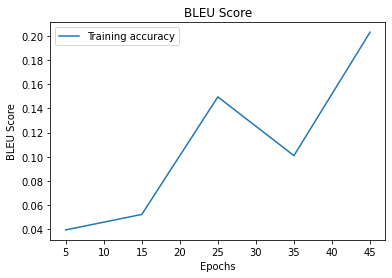

In [86]:
import matplotlib.pyplot as plt
plt.plot(bleu_df_2['epochs'], bleu_df_2['2_gram'], label='Training accuracy')
plt.title('BLEU Score')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
# plt.xticks(range(5, len(list(bleu_df['epochs'])) + 10))
plt.legend()
plt.show()

In [87]:
bleu_df_2

,epochs,1_gram,2_gram,3_gram,4_gram
0,5,0.078416,0.039606,7.234118e-94,2.939069e-155
1,15,0.137228,0.052394,8.556517e-94,3.380410e-155
2,25,0.372475,0.149509,1.605203e-93,5.710360e-155
3,35,0.254852,0.100976,1.268410e-93,4.692866e-155
4,45,0.294060,0.202920,2.041710e-01,1.514487e-01


In [95]:
def generate_song(input_lyrics, model_file, tokenizer_pickle_file, seq_length=50):
    """
    Function to generate a new lyrics
    
    # Arguments
        input_lyrics: Input lyrics of size 50 words used to predict the next 50 words
        model_file: Path of trained model to be used for prediction
        tokenizer_pickle_file: Path of tokenizer pickle file to be used
        
    # Returns
        Prints the input sequence, sequence to be followed & predicted sequence and
        returns Bleu scores considering 1, 2, 3, 4 - grams
    """

    # generate a sequence from a language model
    def generate_seq(model, tokenizer, seq_length, seed_text, n_words):
        result = list()
        in_text = seed_text
        # generate a fixed number of words
        for _ in range(n_words):
            # encode the text as integer
            encoded = tokenizer.texts_to_sequences([in_text])[0]
            # truncate sequences to a fixed length
            encoded = pad_sequences([encoded], maxlen=seq_length, truncating='pre')
            # predict probabilities for each word
            yhat = model.predict_classes(encoded, verbose=0)
            # map predicted word index to word
            out_word = ''
            for word, index in tokenizer.word_index.items():
                if index == yhat:
                    out_word = word
                    break
            # append to input
            in_text += ' ' + out_word
            result.append(out_word)
        return ' '.join(result)

    # load the model
    model = load_model(model_file)

    # load the tokenizer
    tokenizer = load(open(tokenizer_pickle_file, 'rb'))

    # select a seed text
    seed_text = input_lyrics
    print('Input text -----')
    print(seed_text + '\n')
    
    # generate new text
    generated = generate_seq(model, tokenizer, seq_length, seed_text, 50)
    print('Predicted text -----')
    print(generated)

In [96]:
lyrics = "take me with you i do declare i love you dearly through here and there what can i do to make you share what can i do to make you care the world is harsh i'm stuck in the dark i'll make my mark i've got my spark we'd be together"
generate_song(lyrics, '/home/affine/Deep Learning/Ed-Sheeran-Lyrics-Generator-master/Models/bi_rnnglove2565010.0.h5', '/home/affine/Deep Learning/Ed-Sheeran-Lyrics-Generator-master/Models/bi_rnnglove2565010.0_tokenizer.pkl')

/home/affine/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Input text -----
take me with you i do declare i love you dearly through here and there what can i do to make you share what can i do to make you care the world is harsh i'm stuck in the dark i'll make my mark i've got my spark we'd be together

Predicted text -----
soon with the crowds and i'm going too fast and i'll think i say i know she's seems to the man like most of the same time don't make me company this to look gonna make me laugh as we're not friends nor have i wanna runaway now for the
